In [21]:
!pip install scikit-learn xgboost pandas seaborn numpy matplotlib

In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb

# Importing dataset

### Explaining what each feature represents, distinguished by Integer/Categorical data
#### Integer data
* **age (Integer)**: age in years
* **sex (Integer)**: sex ___(1 is male, 0 is female)___
* **trestbps (Integer)**: resting blood pressure (on admission to the hospital)
* **chol (Integer)**: serum cholesterol
* **thalach (Integer)**: maximum heart rate achieved
* **oldpeak (Integer)**: ST depression induced by exercise relative to rest
* **ca (Integer)**: number of major vessels (0-3) colored by flourosopy
* **num (Integer)**: diagnosis of heart disease (angiographic disease status) 
___[Value 0: < 50% diameter narrowing, Value 1: > 50% diameter narrowing]___

#### Categorical data
* **cp (Categorical)**: chest pain type ___(1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)___
* **fbs (Categorical)**: whether fasting blood sugar > 120mg/dl ___(1 = true, 0 = false)___
* **restecg (Categorical)**: resting electrocardiographic results ___(0 = normal, 1 = have ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05mV))___
* **exang (Categorical)**: exercise induced angina ___(1 = yes, 0 = no)___
* **slope (Categorical)**: the slope of the peak exercise ST segment ___(1 = upsloping, 2 = flat, 3 = downsloping)___
* **thal (Categorical)**: ___3 = normal; 6 = fixed defect; 7 = reversable defect___


Note that this dataset omitted quite a number of important features which skews our insights. ie. whether patient is a smoker or not, the number of cigarettes per day, years as smoker. family history of coronary heart disease too. Also, note that no preprocessing was done yet for this dataset, so we'll have to do work on it

In [3]:
# fetching dataset
heart_disease = fetch_ucirepo(id=45) 

# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
z = y.copy()

z['num'] = np.where(z['num'] != 0, 1, 0) # note we combine num = 2, 3, 4 into 1 for binary classification
originalDataframe = pd.concat([X,z], axis=1) # combines labels and features into one DF
heartDisease_combined = originalDataframe

# Splitting into continuous and categorical variables
cont_feat = ['age', 'trestbps', 'chol', 'thalach'] # note i removed oldpeak because it's data is in a smaller range than the rest
cat_feat = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Data Exploration

In [4]:
heartDisease_combined.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [5]:
heartDisease_combined.info()
# which shows that there are no null values in our dataframe, but it appears that there are missing values in ca and thal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int32  
dtypes: float64(3), int32(1), int64(10)
memory usage: 32.1 KB


### Explanation for summary statistics

In the following code below, we explore the summary statistics of each column
* Patient's age ranges from 29 to 77. 25% of patients are 61 years or older, meaning that most patients are fairly young
* In the chest pain (cp) column, people in the 25th percentile experience typical angina (value=1)

In [6]:
# Printing summary stats of each column
summ_stats = heartDisease_combined.describe(include='all')
summ_stats

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


# Data Visualisation

Text(0.5, 1.0, 'Correlation Heatmap')

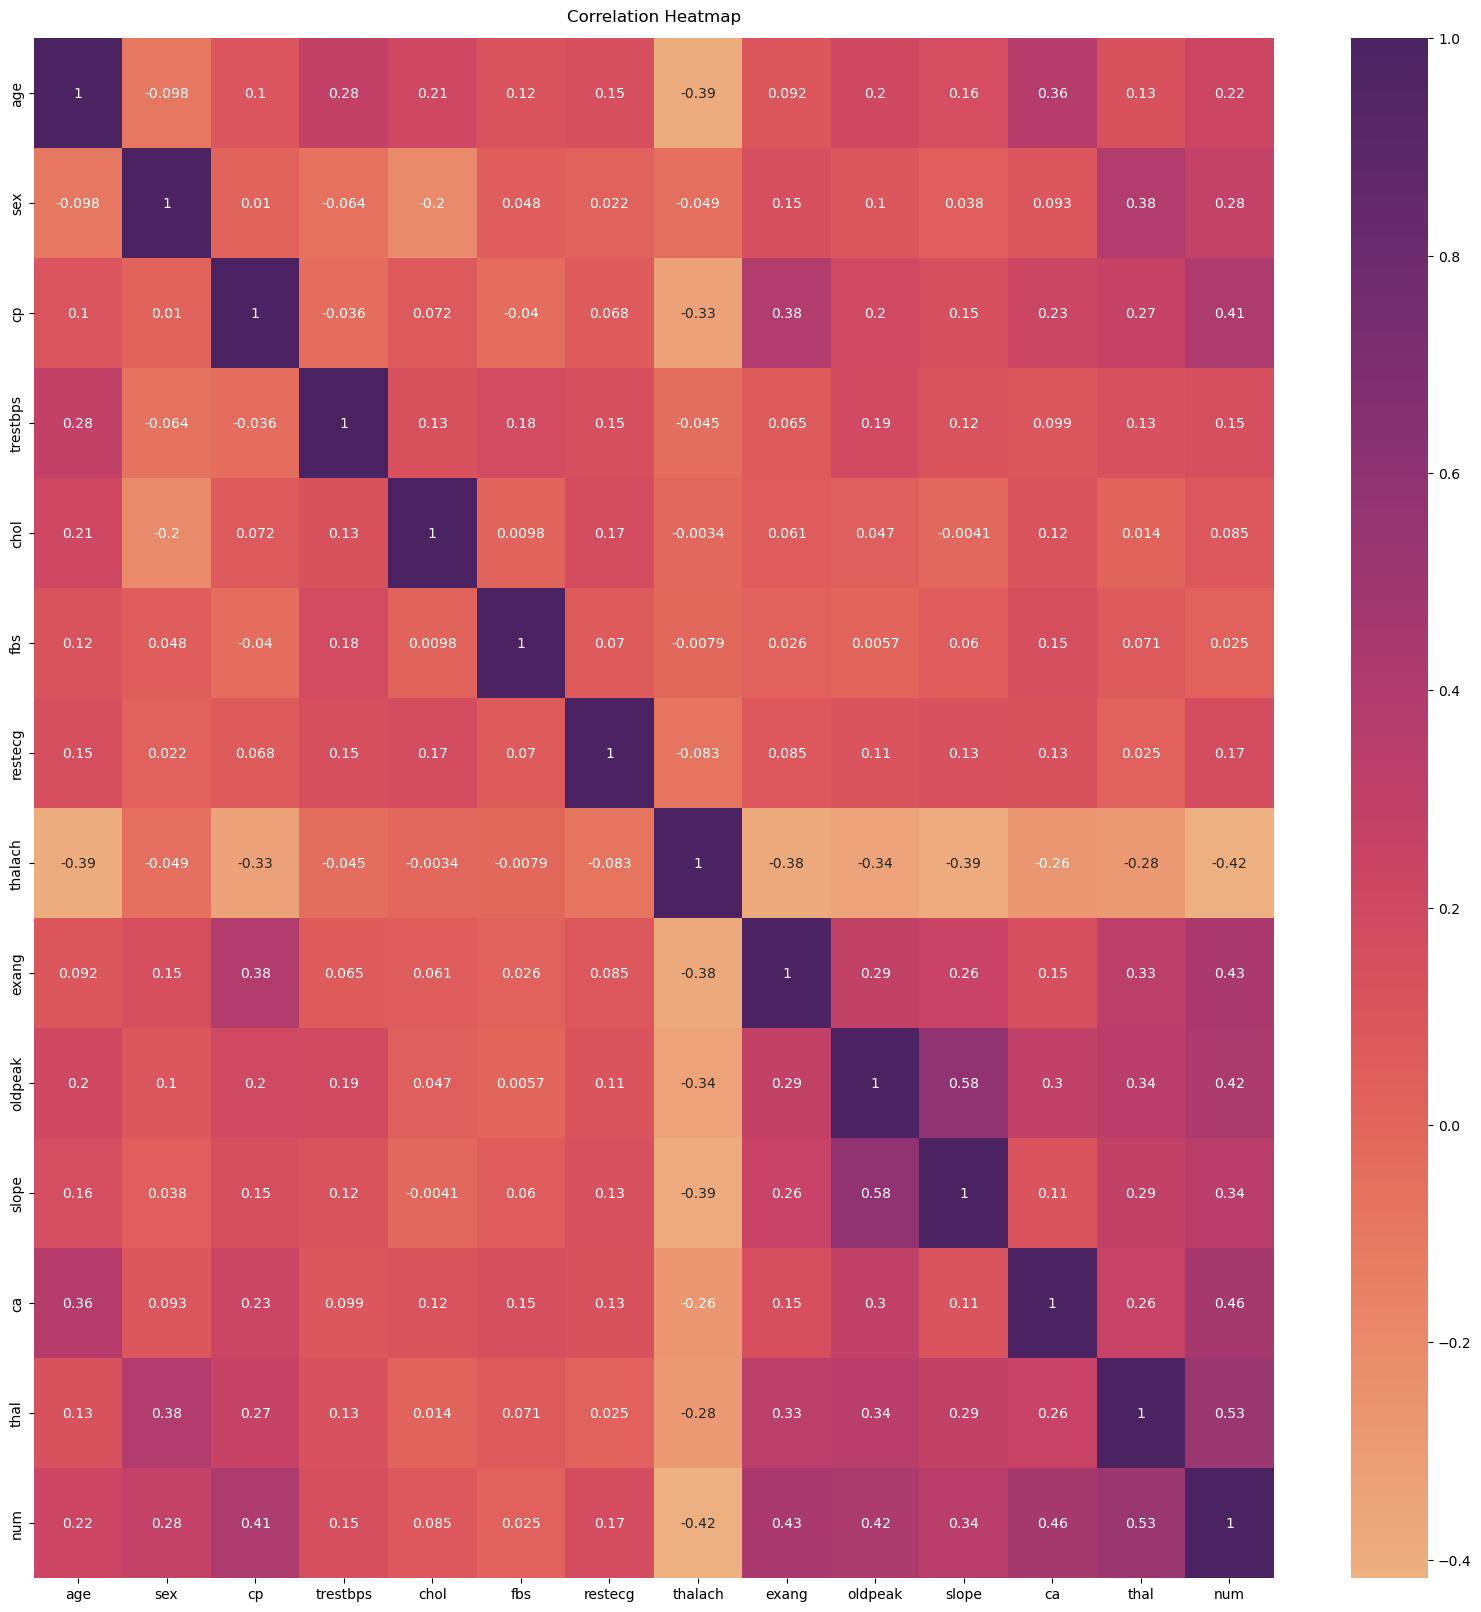

In [7]:
# Printing correlation heatmap, note that darker colours means highly correlated, lighter = not very correlated
plt.figure(figsize=(20,20))
corrHeatmap = sns.heatmap(heartDisease_combined.corr(), cmap='flare', annot=True);
# add annot=True for values, but looks very messy

corrHeatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# cp exang oldpeak slope ca thal 
# highCorr = ['ca', 'exang', 'oldpeak', 'slope', 'thal']
# heartDisease_combined = heartDisease_combined[highCorr + ['num']] # new df with only highly correlated features and num 

### Insights from correlation matrix heatmap

Features that are positively correlated means the higher the presence of that particular feature, the greater the chance to have heart disease. 
- To give an example, chest pain (cp) with correlation of 0.41 means that the higher the presence of chest pain the more likely the person has heart disease

Likewise for negatively correlated features, the higher the presence, the lower the chance for heart disease
- E.g thalach (maximum heart rate achieved) has a negative correlation with presence of heart disease. 



# Preprocessing Steps (Handling missing values and Outliers)

### Handling outliers
- We only include features that are continuous in the boxplot below because categorical features gives us no information
- Note that there are obvious outliers

Text(0.5, 1.0, "Boxplot for 'age', 'trestbps', 'chol', 'thalach'")

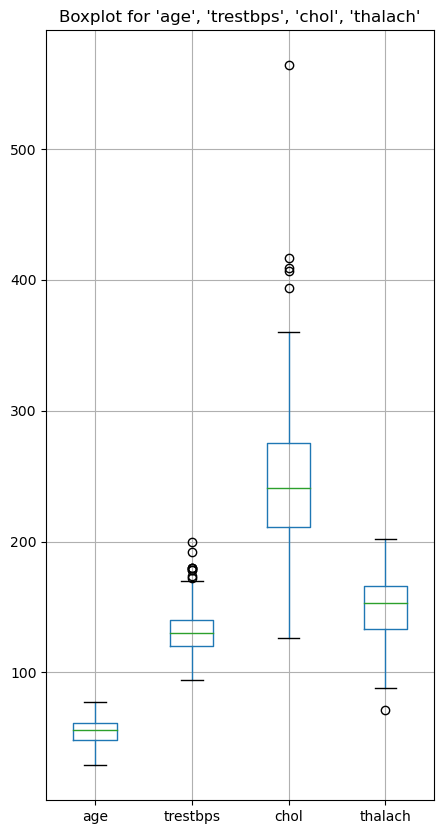

In [8]:
# Handling outliers
cont_hdData = heartDisease_combined[cont_feat]# Slices out continuous categories for boxplot
cont_hdData.boxplot(figsize=(5,10))
plt.title("Boxplot for 'age', 'trestbps', 'chol', 'thalach'")

Text(0.5, 1.0, "Boxplot for 'oldpeak'")

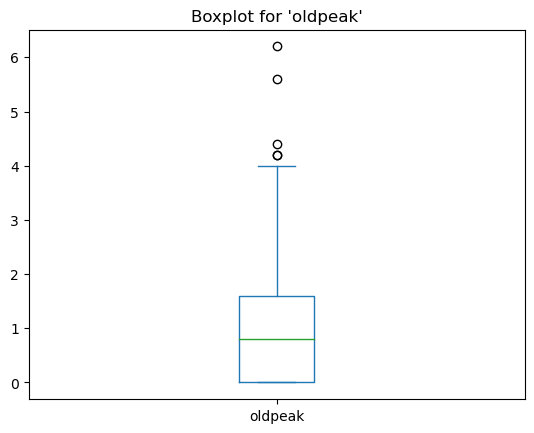

In [9]:
heartDisease_combined['oldpeak'].plot.box()
plt.title("Boxplot for 'oldpeak'")

### Outlier detection using Interquartile Range
- It's important to note that we can only use this method on continuous features
- We use a function to iterate through every column and detect whether the values in that row deviates 1.5x away from IQR from upper/lower quartile
- We obtain the row indexes with the corresponding value of that column from this function
- If there are many outliers that are similar to each other, we don't impute them and instead impute those that are very far from upper/lower quartile

In [10]:
def impute_outliers_with_median(df, column_name):
    median = np.median(df[column_name]) # calculate median within column
    
    percentile25 = df[column_name].quantile(0.25) # calculates quartiles, then IQR for outlier detection
    percentile75 = df[column_name].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    outliers = df[(df[column_name] > upper_limit) | (df[column_name] < lower_limit)] # identifying outliers
    outliers
    
    if not outliers.empty: # prints outliers for reference
        print("Outliers found in column '{}':".format(column_name))
        print(outliers)
    
#     df.loc[outliers.index, column_name] = median # replaces outlier with median
    df.drop(index=outliers.index, inplace=True) # drop rows with outliers
    
    return df

# applies function to all columns by iterating through all columns of continuous features
for columns in cont_feat:
    heartDisease_combined = impute_outliers_with_median(heartDisease_combined, columns)

Outliers found in column 'trestbps':
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
14    52    1   3       172   199    1        0      162      0      0.5   
83    68    1   3       180   274    1        2      150      1      1.6   
126   56    0   4       200   288    1        2      133      1      4.0   
172   59    0   4       174   249    0        0      143      1      0.0   
183   59    1   1       178   270    0        2      145      0      4.2   
188   54    1   2       192   283    0        2      195      0      0.0   
201   64    0   4       180   325    0        0      154      1      0.0   
213   66    0   4       178   228    1        0      165      1      1.0   
231   55    0   4       180   327    0        1      117      1      3.4   

     slope   ca  thal  num  
14       1  0.0   7.0    0  
83       2  0.0   7.0    1  
126      3  2.0   7.0    1  
172      2  0.0   3.0    1  
183      3  0.0   7.0    0  
188      1  1.0   7.0    1  

We notice that row 152 is glaringly large, and therefore is likely the cause of the outlier found in the boxplot. However we impute every outlier according to our IQR rule, and the below boxplot shows the results of our imputation

In [11]:
heartDisease_combined.shape # shows that the shape of the dataframe has not changed

(288, 14)

Text(0.5, 1.0, 'Boxplot for all continuous features')

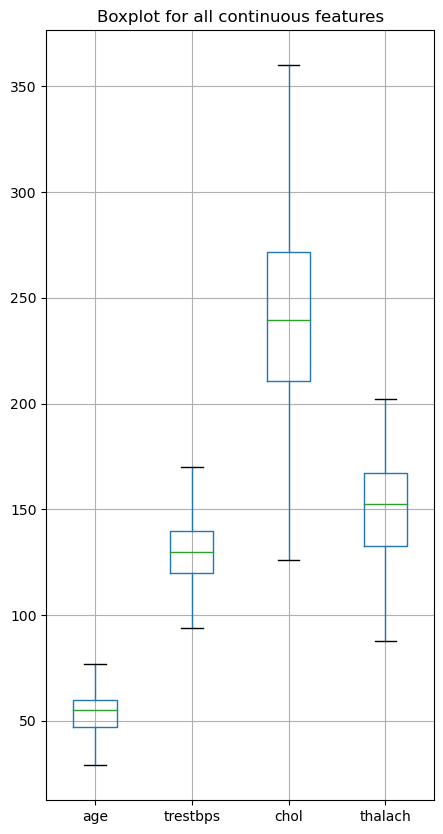

In [12]:
# boxplot after imputation with median. note that most outliers have been imputed
cont_hdData = heartDisease_combined[cont_feat] 
cont_hdData.boxplot(figsize=(5,10))
plt.title("Boxplot for all continuous features")

### Handling missing values

In [13]:
# there are missing values in this dataset, shown by
# print(heart_disease.metadata.has_missing_values)
# print(heart_disease.metadata.missing_values_symbol) # missing values represented by NaN

# Examining missing values
print("Missing value distribution for features:")
print(X.isnull().mean()) # tells us that missing values are found in columns 1% in 'ca' and 0.7% in 'thal', which are very low and thus allows dropping
print(" ") # just whitespace for nicer presentation
print("Missing value distribution for labels")
print(y.isnull().mean())

# attempting dropping of rows. CHECK IF ITS BETTER TO DROP MISSING VALUES OR IMPUTE THEM: 
heartDisease_combined.dropna(axis=0, inplace=True) # drops rows of original dataframe containing NaN values

# heartDisease_combined['ca'].fillna(heartDisease_combined['ca'].median(), inplace=True)
# heartDisease_combined['thal'].fillna(heartDisease_combined['thal'].median(), inplace=True)

print(" ")
print("Checking if cleaned dataset contains missing values")
print(heartDisease_combined.isnull().mean())

Missing value distribution for features:
age         0.000000
sex         0.000000
cp          0.000000
trestbps    0.000000
chol        0.000000
fbs         0.000000
restecg     0.000000
thalach     0.000000
exang       0.000000
oldpeak     0.000000
slope       0.000000
ca          0.013201
thal        0.006601
dtype: float64
 
Missing value distribution for labels
num    0.0
dtype: float64
 
Checking if cleaned dataset contains missing values
age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
num         0.0
dtype: float64


# Normalising dataset (does not affect gradient boosted trees)

# Gradient Boosting

## XGB with GridSearchCV for hyperparameter tuning

Note that this idea was scrapped as it could not find a better accuracy than manual attempts, but the code was left commented here just to show it was attempted

In [14]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score
# import numpy as np

# a = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# X = heartDisease_combined[a]
# Y = heartDisease_combined['num']
# X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# print("Step 1: Data Splitting") 
# # parameter grid for GridSearch
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 1.0, 100],
#     'n_estimators': [100, 200, 300],
#     'alpha': [1, 5, 10],
# }


# print("Step 2: Parameter Grid Definition")
# # instantiates xgbclassifier
# xgb_model = XGBClassifier(objective='binary:logistic')


# print("Step 3: XGBoost Classifier Instantiation")
# # instantiates gridsearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# print("Step 4: GridSearchCV Instantiation")
# # performs gridsearch for best hyperparameters
# grid_search.fit(X_train, y_train)


# print("Step 5: Grid Search")
# # obtains best hyperparameters
# best_params = grid_search.best_params_
# print("Best hyperparameters:", best_params)

# # obtains best model
# best_model = grid_search.best_estimator_


# print("Step 6: Best Model Extraction")
# # use best model for predictions on test set
# y_pred = best_model.predict(X_test)

# print("Step 7: Prediction")

# print("Step 8: Evaluation")
# # evaluate model accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print("The accuracy score achieved using the best model is: {:.2f}%".format(accuracy * 100))

## Vanilla XGB

Note that this is the final XGB Model used for the report

In [15]:
###### from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
a = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

X = heartDisease_combined[a]
Y = heartDisease_combined['num']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }
            
# instantiate the classifier 
xgb_model = xgb.XGBClassifier(**params)

# fit the classifier to the training data
xgb_model.fit(X_train, y_train)
Y_pred_xgb = xgb_model.predict(X_test)
score_xgb = round(accuracy_score(Y_pred_xgb,y_test)*100,2)

print("The accuracy score achieved using XGBoost is: "+str(score_xgb)+" %")
# accuracy decreases when we remove missing values (when we use highCorr dataset instead. Otherwise, accuracy increases)
# for some reasons when we include all features, even the not very uncorrelated ones the accuracy increases


# https://gist.github.com/pb111/cc341409081dffa5e9eaf60d79562a03
# https://github.com/g-shreekant/Heart-Disease-Prediction-using-Machine-Learning/blob/master/Heart_disease_prediction.ipynb

The accuracy score achieved using XGBoost is: 87.72 %


## Confusion Matrix

True Positive: 32
False Positive: 4

False Negative: 4
True Negative: 20


In [16]:
from sklearn.metrics import confusion_matrix

# Example true labels and predicted labels (replace with your actual data)
true_labels = y_test
predicted_labels = Y_pred_xgb
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[27  2]
 [ 5 23]]


## Plotting feature importance

Plotting feature importance: tells us what feature was valuable in constructing the boosted decision tree within the model

In other words, 'ca', 'thalach' and 'cp' was important in determining presence of heart disease

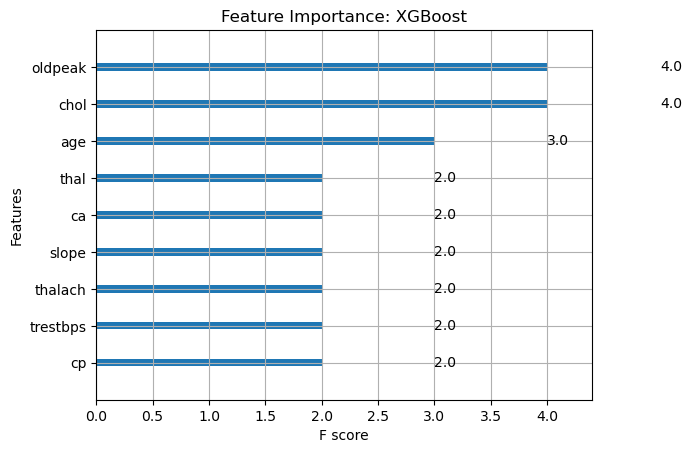

In [17]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.title("Feature Importance: XGBoost")
plt.show()